In [1]:
#!pip3 install pandas
#!pip3 install xgboost
#!pip3 install sklearn
#!pip3 install six==1.10
#!pip3 install matplotlib
#!pip3 install statsmodels
#!pip3 install keras==2.2
#!pip3 install tensorflow
#!pip3 install np_utils
#!pip3 install opencv-python
#!pip3 install optunity
#!pip3 install pydot-ng
#!pip3 install pydot
#!pip3 install tensorboard
#!pip3 uninstall pyparsing -f -y
#!pip3 install --ignore-installed -U ipython
#!pip3 install pyparsing
#!pip3 install graphviz
#!pip3 install --ignore-installed pydot>=1.2.4

In [146]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
import math
import random
import pydot

from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost import plot_tree

#from graphviz import Digraph

from sklearn import cross_validation, metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import cv2
import h5py

from math import sqrt

import optunity
import optunity.metrics

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from keras.utils import vis_utils as vizu
from keras import callbacks
from keras import backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Load Data

In [3]:
kyoto_1_score = pd.read_csv('dataset/data1_score.csv')
kyoto_1_score.head(5)

,userid,score
0,ds101,80
1,ds102,80
2,ds103,60
3,ds104,50
4,ds105,100


In [4]:
kyoto_1_all = pd.read_csv('dataset/dataset1_15features.csv')
kyoto_1_p1 = pd.read_csv('dataset/total01_1213.csv')
kyoto_1_p2 = pd.read_csv('dataset/total01_0123~0124.csv')
kyoto_1_p3 = pd.read_csv('dataset/total01_1122.csv')
kyoto_week = pd.read_csv('dataset/Week1filter.csv')


kyoto_1_all.rename(index=str, columns={"Userid": "userid"}, inplace=True)
kyoto_1_all = kyoto_1_all.drop(['Score'], axis=1)

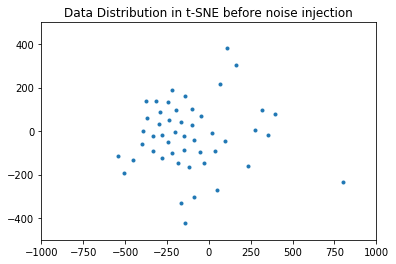

In [5]:
k_temp = kyoto_1_all.drop(['userid'], axis=1)

tsne = TSNE(perplexity =30, n_components=2, init='pca', n_iter=300)
k_temp = tsne.fit_transform(k_temp)

fig, axes = plt.subplots()
axes.set_xlim([-1000, 1000])
axes.set_ylim([-500, 500])
axes.set_title('Data Distribution in t-SNE before noise injection')
axes.plot(k_temp[:,0], k_temp[:,1], '.')


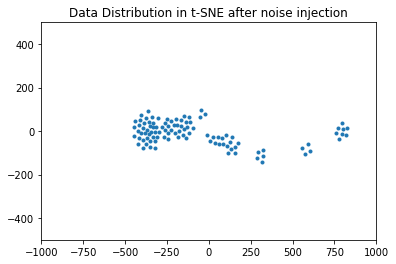

In [6]:
k_temp = kyoto_1_all.drop(['userid'], axis=1)

noise1 = kyoto_1_all[list(k_temp)].mul(np.random.normal(1.0, 0.5, size=len(kyoto_1_all)), axis=0)
noise1 = noise1.join(kyoto_1_all['userid'].to_frame())

#noise2 = kyoto_1_all[list(k_temp)].mul(np.random.normal(1.0, 0.5, size=len(kyoto_1_all)), axis=0)
#noise2 = noise2.join(kyoto_1_all['userid'].to_frame())

kyoto_1_all = pd.concat([kyoto_1_all, noise1])
#kyoto_1_all = pd.concat([kyoto_1_all, noise2])

k_temp = kyoto_1_all.drop(['userid'], axis=1)
k_temp = tsne.fit_transform(k_temp)

fig, axes = plt.subplots()
axes.set_xlim([-1000, 1000])
axes.set_ylim([-500, 500])
axes.set_title('Data Distribution in t-SNE after noise injection')
axes.plot(k_temp[:,0], k_temp[:,1], '.')


# Merge Datasets

In [7]:
kyoto_x_all = pd.merge(kyoto_1_all, kyoto_1_score, on='userid')
kyoto_x_1 = pd.merge(kyoto_1_p1, kyoto_1_score, on='userid')
kyoto_x_2 = pd.merge(kyoto_1_p2, kyoto_1_score, on='userid')
kyoto_x_3 = pd.merge(kyoto_1_p3, kyoto_1_score, on='userid')
kyoto_week = pd.merge(kyoto_1_p3, kyoto_1_score, on='userid')

In [8]:
kyoto_x_p = kyoto_x_1.append([kyoto_x_2, kyoto_x_3])
kyoto_x_p.rename(index=str, columns={"ADD BOOKMARK": "Add_BookmarkC"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"CLOSE": "closec"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"MARKERC": "markerc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"MEMOC": "memoc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"OPEN": "openc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"PAGE_JUMP": "Page_JumpC"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"mobile": "mobilec"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"pc": "pcc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"tablet": "tabletc"}, inplace=True)
#set(kyoto_1)

In [9]:
kyoto_1 = kyoto_x_all
#kyoto_1 = kyoto_x_p
#kyoto_1 = kyoto_week
#kyoto_1 = pd.concat([kyoto_x_all, kyoto_x_p])


kyoto_1.fillna(0.0, inplace=True)
kyoto_1 = kyoto_1.drop(['userid'], axis=1)
kyoto_1 = kyoto_1.drop(['Delete_Memo'], axis=1)

'''
kyoto_1 = kyoto_1.drop(['PREV'], axis=1)
kyoto_1 = kyoto_1.drop(['NEXT'], axis=1)
kyoto_1 = kyoto_1.drop(['Readtime(seconds)'], axis=1)
kyoto_1 = kyoto_1.drop(['pcc'], axis=1)
kyoto_1 = kyoto_1.drop(['tabletc'], axis=1)
kyoto_1 = kyoto_1.drop(['LINK_CLICK'], axis=1)
kyoto_1 = kyoto_1.drop(['SEARCH_JUMP'], axis=1)
kyoto_1 = kyoto_1.drop(['memoc'], axis=1)
kyoto_1 = kyoto_1.drop(['Add_BookmarkC'], axis=1)
kyoto_1 = kyoto_1.drop(['Delete_BookmarkC'], axis=1)
kyoto_1 = kyoto_1.drop(['Add_MemoC'], axis=1)
kyoto_1 = kyoto_1.drop(['Delete_MemoC'], axis=1)
kyoto_1 = kyoto_1.drop(['Change_MemoC'], axis=1)
kyoto_1 = kyoto_1.drop(['Add_MarkerC'], axis=1)
kyoto_1 = kyoto_1.drop(['Delete_MarkerC'], axis=1)
kyoto_1 = kyoto_1.drop(['bookmarkc'], axis=1)
kyoto_1 = kyoto_1.drop(['closec'], axis=1)
kyoto_1 = kyoto_1.drop(['markerc'], axis=1)
kyoto_1 = kyoto_1.drop(['SEARCH'], axis=1)
kyoto_1 = kyoto_1.drop(['mobilec'], axis=1)
kyoto_1 = kyoto_1.drop(['JUMPC'], axis=1)
'''

kyoto_1 = kyoto_1[kyoto_1['score']>0]
#list(kyoto_1)[11]

#kyoto_1 = kyoto_1.drop([list(kyoto_1)[14]], axis=1)

# Preprocess

In [10]:

#outlier = 3
#kyoto_1 = kyoto_1[np.abs(kyoto_1.pcc-kyoto_1.pcc.mean()) <= (outlier * kyoto_1.pcc.std())]
#kyoto_1 = kyoto_1[np.abs(kyoto_1.tabletc-kyoto_1.tabletc.mean()) <= (outlier * kyoto_1.tabletc.std())]
#kyoto_1 = kyoto_1 * 10
#kyoto_1 = np.log(kyoto_1)
#kyoto_1.fillna(0.0, inplace=True)
#kyoto_1 = (kyoto_1 - kyoto_1.mean()) / (kyoto_1.max() - kyoto_1.min()) * 10
#kyoto_1.fillna(0.0, inplace=True)

#kyoto_1
#kyoto_1.plot.box(sym='r+')

In [11]:

kyoto_y = kyoto_1['score']
kyoto_x = kyoto_1.drop(['score'], axis=1)


# Add noise

In [12]:
#kyoto_x * np.random.normal(1.0, sd, size=len(kyoto_x))
#kyoto_x = pd.concat([kyoto_x, kyoto_x.mul(np.random.normal(1.0, 0.5, size=len(kyoto_x)), axis=0)])
#kyoto_x = pd.concat([kyoto_x, kyoto_x.mul(np.random.normal(1.0, 0.5, size=len(kyoto_x)), axis=0)])
#kyoto_y = pd.concat([kyoto_y, kyoto_x.mul(np.random.normal(1.0, 0.5, size=len(kyoto_y)), axis=0)])
#kyoto_y = pd.concat([kyoto_y, kyoto_x.mul(np.random.normal(1.0, 0.5, size=len(kyoto_y)), axis=0)])

# Train Model

In [13]:
xgb2 = XGBRegressor(n_estimators=20000, 
                    learning_rate=0.01, 
                    gamma=0.1, 
                    subsample=0.9,
                    colsample_bytree=0.9, 
                    max_depth=5)

In [14]:
def xgb_modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='mae', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mae')
        
    return alg

In [15]:
def svr_modelfitting(x_train, y_train):
    """Computes MSE of an SVR with RBF kernel and optimized hyperparameters."""
    
    # define objective function for tuning
    @optunity.cross_validated(x=x_train, y=y_train, num_iter=2, num_folds=5)
    def tune_cv(x_train, y_train, C, degree, coef0):
        model = sklearn.svm.SVR(C=C, degree=degree, coef0=coef0, kernel='poly').fit(x_train, y_train)
        predictions = model.predict(x_train)
        return optunity.metrics.mse(y_train, predictions)

    # optimize parameters
    optimal_pars, _, _ = optunity.minimize(tune_cv, 
                                           150, 
                                           C=[1000, 20000], 
                                           degree=[2, 5], 
                                           coef0=[0, 1])
    #print("optimal hyperparameters: " + str(optimal_pars))

    tuned_model = sklearn.svm.SVR(kernel='poly', **optimal_pars).fit(x_train, y_train)

    return tuned_model


In [16]:
mlp = MLPRegressor(hidden_layer_sizes=(2,),
                   activation='relu',
                   solver='adam',
                   learning_rate='adaptive',
                   max_iter=20000,
                   learning_rate_init=0.01,
                   alpha=0.01)

In [ ]:
def baseline_model():
    
    def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=14, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GaussianNoise(0.1))
    model.add(Dense(8, input_dim=8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    #model.compile(loss='mse', optimizer='adam')
    return model

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mse_xgb_list = []
mse_pcx_list = []
mse_ols_list = []
mse_svr_list = []
mse_mlp_list = []
mse_pcr_list = []
mse_regr_list = []
mse_knn_list = []

mape_xgb_list = []
mape_pcx_list = []
mape_regr_list = []
mape_ols_list = []
mape_svr_list = []
mape_mlp_list = []
mape_pcr_list = []
mape_knn_list = []

r2_xgb_list = []
r2_xgb_list = []
r2_pcx_list = []
r2_regr_list = []
r2_ols_list = []
r2_svr_list = []
r2_mlp_list = []
r2_pcr_list = []
r2_knn_list = []

tl_knn_list = []
tl_svr_list = []
tl_pcx_list = []
tl_xgb_list = []
tl_regr_list = []
tl_ols_list = []
tl_mlp_list = []
tl_pcr_list = []

for i in range(0, 2):
    
    print (i)
    
    X_train, X_test, y_train, y_test = train_test_split(kyoto_x, kyoto_y, test_size=0.3)
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.fit_transform(X_test)
    
    # XGBoost
    xgb_model = xgb_modelfit(xgb2, X_train, y_train)
    #xgb2.fit(X_train, y_train)
    xgr_pred_y = xgb_model.predict(X_test)
    mse_xgb_list.append(sqrt(mean_squared_error(y_test, xgr_pred_y)))
    mape_xgb_list.append(((y_test - xgr_pred_y) / y_test).abs().mean()*100)
    r2_xgb_list.append(r2_score(xgr_pred_y, y_test))
    xgr_pred_y = xgb_model.predict(X_train)
    tl_xgb_list.append(r2_score(xgr_pred_y, y_train))
    
    # PCX
    pca = PCA(n_components=9)# adjust yourself
    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)    
    #xgb2.fit(X_pca_train, y_train)
    xgb_model = xgb_modelfit(xgb2, X_pca_train, y_train)
    pcx_pred_y = xgb_model.predict(X_pca_test)
    mse_pcx_list.append(sqrt(mean_squared_error(y_test, pcx_pred_y)))
    mape_pcx_list.append(((y_test - pcx_pred_y) / y_test).abs().mean()*100)
    r2_pcx_list.append(r2_score(y_test, pcx_pred_y))
    pcx_pred_y = xgb_model.predict(X_pca_train)
    tl_pcx_list.append(sqrt(mean_squared_error(y_train, pcx_pred_y)))
    
    # Random Forest Regressor
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred_y = regr.predict(X_test)
    mse_regr_list.append(sqrt(mean_squared_error(y_test, regr_pred_y)))
    mape_regr_list.append(((y_test - regr_pred_y) / y_test).abs().mean()*100)
    r2_regr_list.append(r2_score(y_test, regr_pred_y))
    regr_pred_y = regr.predict(X_train)
    tl_regr_list.append(r2_score(y_train, regr_pred_y))
    
    # linear regression
    ols_model = sm.OLS(endog=y_train, exog=X_train)
    ols_model = ols_model.fit()
    ols_pred_y = ols_model.predict(exog=X_test)
    mse_ols_list.append(sqrt(mean_squared_error(y_test, ols_pred_y)))
    mape_ols_list.append(((y_test - ols_pred_y) / y_test).abs().mean()*100)
    r2_ols_list.append(r2_score(y_test, ols_pred_y))
    ols_pred_y = ols_model.predict(exog=X_train)
    tl_ols_list.append(sqrt(mean_squared_error(y_train, ols_pred_y)))
    
    # support vector regression
    clf = SVR(C=1.0, epsilon=0.2)
    #svr_model = svr_modelfitting(X_train, y_train)
    svr_model = clf.fit(X_train, y_train) 
    svr_pred_y = svr_model.predict(X_test)
    mse_svr_list.append(sqrt(mean_squared_error(y_test, svr_pred_y)))
    mape_svr_list.append(((y_test - svr_pred_y) / y_test).abs().mean()*100)
    r2_svr_list.append(r2_score(y_test, svr_pred_y))
    svr_pred_y = svr_model.predict(X_train)
    tl_svr_list.append(sqrt(mean_squared_error(y_train, svr_pred_y)))
    
    # Multi-layer Perceptron regressor
    mlp_model = mlp.fit(X_train, y_train)
    mlp_pred_y = mlp_model.predict(X_test)
    mse_mlp_list.append(sqrt(mean_squared_error(y_test, mlp_pred_y)))
    mape_mlp_list.append(((y_test - mlp_pred_y) / y_test).abs().mean()*100)
    r2_mlp_list.append(r2_score(y_test, mlp_pred_y))
    mlp_pred_y = mlp_model.predict(X_train)
    tl_mlp_list.append(sqrt(mean_squared_error(y_train, mlp_pred_y)))
    
    # Princple Componment Regression
    pca = PCA(n_components=9)# adjust yourself
    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)
    pcr_model = sm.OLS(endog=y_train, exog=X_pca_train)
    pcr_model = pcr_model.fit()
    pcr_pred_y = pcr_model.predict(exog=X_pca_test)
    mse_pcr_list.append(sqrt(mean_squared_error(y_test, pcr_pred_y)))
    mape_pcr_list.append(((y_test - pcr_pred_y) / y_test).abs().mean()*100)
    r2_pcr_list.append(r2_score(y_test, pcr_pred_y))
    pcr_pred_y = pcr_model.predict(exog=X_pca_train)
    tl_pcr_list.append(sqrt(mean_squared_error(y_train, pcr_pred_y)))
    
    # keras NN
    knn = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=1, verbose=0)
    knn.fit(X_train, y_train)
    knn_pred_y = knn.predict(X_test)
    mse_knn_list.append(sqrt(mean_squared_error(y_test, knn_pred_y)))
    mape_knn_list.append(((y_test - knn_pred_y) / y_test).abs().mean()*100)
    r2_knn_list.append(r2_score(y_test, knn_pred_y))
    knn_pred_y = knn.predict(X_train)
    tl_knn_list.append(sqrt(mean_squared_error(y_train, knn_pred_y)))
    vizu.plot_model(knn.model, "keras_model.png", show_layer_names=True, show_shapes=True)


0
1


# Boxplot

[Text(0,0,'XGBoost'),
 Text(0,0,'PCXGBoox'),
 Text(0,0,'RFR'),
 Text(0,0,'SVR'),
 Text(0,0,'MLR'),
 Text(0,0,'PCR'),
 Text(0,0,'ANN'),
 Text(0,0,'Keras')]

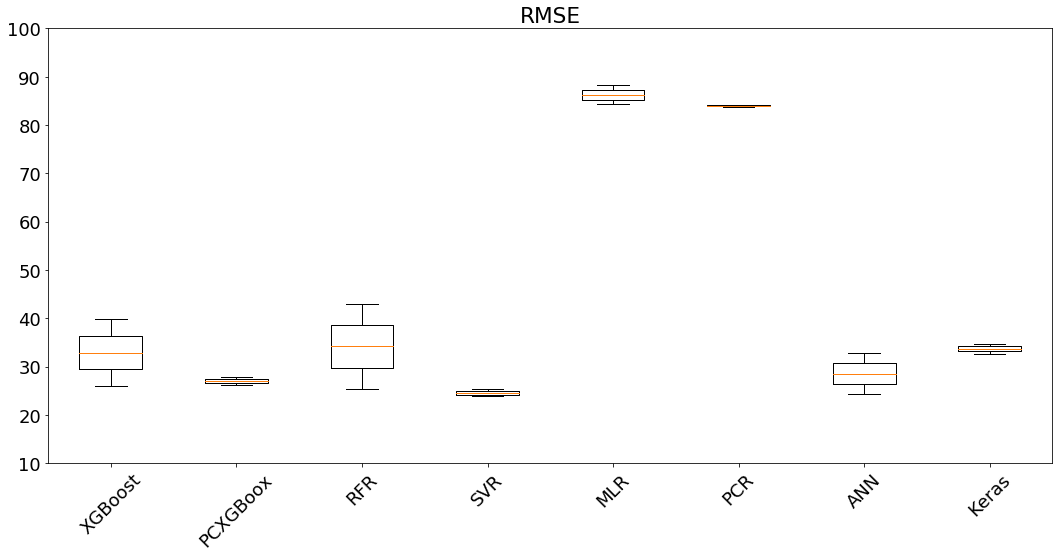

In [20]:
matplotlib.rcParams.update({'font.size': 18})

fig1, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_title('RMSE')
box_data = [mse_xgb_list,
            mse_pcx_list, 
            mse_regr_list,
            mse_svr_list, 
            mse_ols_list,
            mse_pcr_list,
            mse_mlp_list, 
            mse_knn_list]

#ax1.set_yscale('log')
ax1.boxplot(box_data)
ax1.set_ylim([10, 100])
ax1.set_xticklabels(['XGBoost',
                     'PCXGBoox', 
                     'RFR', 
                     'SVR', 
                     'MLR',
                     'PCR',
                     'ANN', 
                     'Keras'], rotation=45)

In [21]:
print ('MSE XGBoost:', '{:.2f}'.format(sum(mse_xgb_list) / len(mse_xgb_list)))
print ('MSE PCXGBoost:', '{:.2f}'.format(sum(mse_pcx_list) / len(mse_pcx_list)))
print ('MSE Random Forest Regression:', '{:.2f}'.format(sum(mse_regr_list) / len(mse_regr_list)))
print ('MSE Support Vector Regression:', '{:.2f}'.format(sum(mse_svr_list) / len(mse_svr_list)))
print ('MSE Artificial Neural Network:', '{:.2f}'.format(sum(mse_mlp_list) / len(mse_mlp_list)))
print ('MSE Mutiple Linear Regression:', '{:.2f}'.format(sum(mse_ols_list) / len(mse_ols_list)))
print ('MSE Principle Component Regression:', '{:.2f}'.format(sum(mse_pcr_list) / len(mse_pcr_list)))
print ('MSE Keras Neural Network:', '{:.2f}'.format(sum(mse_knn_list) / len(mse_knn_list)))

MSE XGBoost: 32.92
MSE PCXGBoost: 27.03
MSE Random Forest Regression: 34.18
MSE Support Vector Regression: 24.58
MSE Artificial Neural Network: 28.51
MSE Mutiple Linear Regression: 86.25
MSE Principle Component Regression: 83.99
MSE Keras Neural Network: 33.73


[Text(0,0,'XGBoost'),
 Text(0,0,'PCXGBoox'),
 Text(0,0,'RFR'),
 Text(0,0,'SVR'),
 Text(0,0,'ANN'),
 Text(0,0,'PCR'),
 Text(0,0,'Keras')]

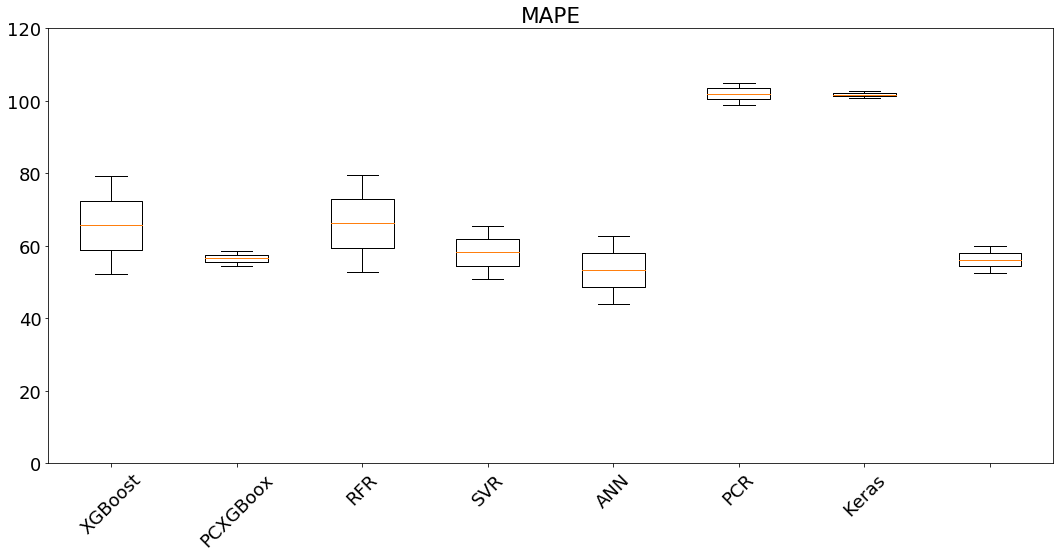

In [22]:
fig1, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_title('MAPE')
box_data = [mape_xgb_list,
            mape_pcx_list, 
            mape_regr_list,
            mape_svr_list, 
            mape_mlp_list, 
            mape_ols_list, 
            mape_pcr_list,
            mape_knn_list]

#ax1.set_yscale('log')
ax1.boxplot(box_data)
ax1.set_ylim([0, 120])
ax1.set_xticklabels(['XGBoost',
                     'PCXGBoox', 
                     'RFR', 
                     'SVR', 
                     'ANN', 
                     'PCR',
                     'Keras'], rotation=45)

In [23]:
print ('MAPE XGBoost:', '{:.2f}'.format(sum(mape_xgb_list) / len(mape_xgb_list)))
print ('MAPE PCXGBoost:', '{:.2f}'.format(sum(mape_pcx_list) / len(mape_pcx_list)))
print ('MAPE Random Forest Regression:', '{:.2f}'.format(sum(mape_regr_list) / len(mape_regr_list)))
print ('MAPE Support Vector Regression:', '{:.2f}'.format(sum(mape_svr_list) / len(mape_svr_list)))
print ('MAPE Artificial Neural Network:', '{:.2f}'.format(sum(mape_mlp_list) / len(mape_mlp_list)))
print ('MAPE Mutiple Linear Regression:', '{:.2f}'.format(sum(mape_ols_list) / len(mape_ols_list)))
print ('MAPE Principle Component Regression:', '{:.2f}'.format(sum(mape_pcr_list) / len(mape_pcr_list)))
print ('MAPE Keras Neural Network:', '{:.2f}'.format(sum(mape_knn_list) / len(mape_knn_list)))

MAPE XGBoost: 65.67
MAPE PCXGBoost: 56.50
MAPE Random Forest Regression: 66.22
MAPE Support Vector Regression: 58.21
MAPE Artificial Neural Network: 53.38
MAPE Mutiple Linear Regression: 101.96
MAPE Principle Component Regression: 101.75
MAPE Keras Neural Network: 56.21


In [24]:
print ('R2 XGBoost:', '{:.2f}'.format(sum(r2_xgb_list) / len(r2_xgb_list)))
print ('R2 PCXGBoost:', '{:.2f}'.format(sum(r2_pcx_list) / len(r2_pcx_list)))
print ('R2 Random Forest Regression:', '{:.2f}'.format(sum(r2_regr_list) / len(r2_regr_list)))
print ('R2 Support Vector Regression:', '{:.2f}'.format(sum(r2_svr_list) / len(r2_svr_list)))
print ('R2 Artificial Neural Network:', '{:.2f}'.format(sum(r2_mlp_list) / len(r2_mlp_list)))
print ('R2 Mutiple Linear Regression:', '{:.2f}'.format(sum(r2_ols_list) / len(r2_ols_list)))
print ('R2 Principle Component Regression:', '{:.2f}'.format(sum(r2_pcr_list) / len(r2_pcr_list)))
print ('R2 Keras Neural Network:', '{:.2f}'.format(sum(r2_knn_list) / len(r2_knn_list)))

R2 XGBoost: -3.07
R2 PCXGBoost: -0.19
R2 Random Forest Regression: -0.99
R2 Support Vector Regression: 0.02
R2 Artificial Neural Network: -0.34
R2 Mutiple Linear Regression: -11.15
R2 Principle Component Regression: -10.50
R2 Keras Neural Network: -0.85


In [25]:
print ('Training Loss XGBoost:', '{:.2f}'.format(sum(tl_xgb_list) / len(tl_xgb_list)))
print ('Training Loss PCXGBoost:', '{:.2f}'.format(sum(tl_pcx_list) / len(tl_pcx_list)))
print ('Training Loss Random Forest Regression:', '{:.2f}'.format(sum(tl_regr_list) / len(tl_regr_list)))
print ('Training Loss Support Vector Regression:', '{:.2f}'.format(sum(tl_svr_list) / len(tl_svr_list)))
print ('Training Loss Artificial Neural Network:', '{:.2f}'.format(sum(tl_mlp_list) / len(tl_mlp_list)))
print ('Training Loss Mutiple Linear Regression:', '{:.2f}'.format(sum(tl_ols_list) / len(tl_ols_list)))
print ('Training Loss Principle Component Regression:', '{:.2f}'.format(sum(tl_pcr_list) / len(tl_pcr_list)))
print ('Training Loss Keras Neural Network:', '{:.2f}'.format(sum(tl_knn_list) / len(tl_knn_list)))

Training Loss XGBoost: 0.97
Training Loss PCXGBoost: 2.44
Training Loss Random Forest Regression: 0.74
Training Loss Support Vector Regression: 21.14
Training Loss Artificial Neural Network: 17.32
Training Loss Mutiple Linear Regression: 81.18
Training Loss Principle Component Regression: 81.29
Training Loss Keras Neural Network: 24.60


In [26]:
# https://github.com/amirhessam88/Regression-Error-Characteristic-Curve/blob/master/REC.ipynb
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
# http://optunity.readthedocs.io/en/latest/
'''
for i in range(1,2):
    print(i)
    knn = KerasRegressor(build_fn=baseline_model, epochs=5000, batch_size=1, verbose=0)
    knn.fit(X_train, y_train)
    knn_pred_y = knn.predict(X_test)
    mse_knn_list.append(sqrt(mean_squared_error(y_test, knn_pred_y)))
    mape_knn_list.append(((y_test - knn_pred_y) / y_test).abs().mean()*100)
    r2_knn_list.append(r2_score(y_test, knn_pred_y))
    knn_pred_y = knn.predict(X_train)
    tl_knn_list.append(sqrt(mean_squared_error(y_train, knn_pred_y)))
    vizu.plot_model(knn.model, "keras_model.png", show_layer_names=True, show_shapes=True)
'''

'\nfor i in range(1,2):\n    print(i)\n    knn = KerasRegressor(build_fn=baseline_model, epochs=5000, batch_size=1, verbose=0)\n    knn.fit(X_train, y_train)\n    knn_pred_y = knn.predict(X_test)\n    mse_knn_list.append(sqrt(mean_squared_error(y_test, knn_pred_y)))\n    mape_knn_list.append(((y_test - knn_pred_y) / y_test).abs().mean()*100)\n    r2_knn_list.append(r2_score(y_test, knn_pred_y))\n    knn_pred_y = knn.predict(X_train)\n    tl_knn_list.append(sqrt(mean_squared_error(y_train, knn_pred_y)))\n    vizu.plot_model(knn.model, "keras_model.png", show_layer_names=True, show_shapes=True)\n'

![title](./keras_model.png)

In [ ]:
knn = KerasRegressor(build_fn=baseline_model, epochs=6000, batch_size=1, verbose=0)

model = knn.fit(X_train, y_train, validation_data=(X_test, y_test))
epochs = range(1,len(model.history['loss']) + 1)

x = np.array(model.history['loss']).astype(int)
y = np.sqrt(np.abs(x)) * np.sign(x)

plt.figure()
plt.plot(epochs, y, '.-', label='loss (' + str(format(y[-1], '.2f')) +')')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
knn = KerasRegressor(build_fn=baseline_model, epochs=6000, batch_size=1, verbose=0)

patience = 3

stopper = callbacks.EarlyStopping(monitor='acc', patience=patience)
model = knn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stopper])
epochs = range(1,len(model.history['loss']) + 1)

x = np.array(model.history['loss']).astype(int)
y = np.sqrt(np.abs(x)) * np.sign(x)

plt.figure()
plt.plot(epochs, y, '.-', label='loss (' + str(format(y[-1], '.2f')) +')')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
x = np.array(model.history['val_loss']).astype(int)
y = np.sqrt(np.abs(x)) * np.sign(x)

plt.figure()
plt.plot(epochs, y, '.-', label='loss (' + str(format(y[-1], '.2f')) +')')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()